# PDE-FIND for identifying Navier-Stokes

Samuel Rudy, 2016

This notebook demonstrates PDE-FIND for the vorticity equation given a simulation of fluid flowing around a cylinder.
\begin{align*}
\omega_t &= \frac{1}{Re}\nabla^2 \omega - (V \cdot \nabla)\omega\\
V &= (v,u)\\
Re &= 100
\end{align*}
The x and y components of the velocity field are given as forcing terms to the PDE.  That is, they appear in $\Theta$, but are not differentiated.

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 6)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import sys; sys.path.append('../')
from PDE_FIND import *
import scipy.io as sio
import itertools

Populating the interactive namespace from numpy and matplotlib


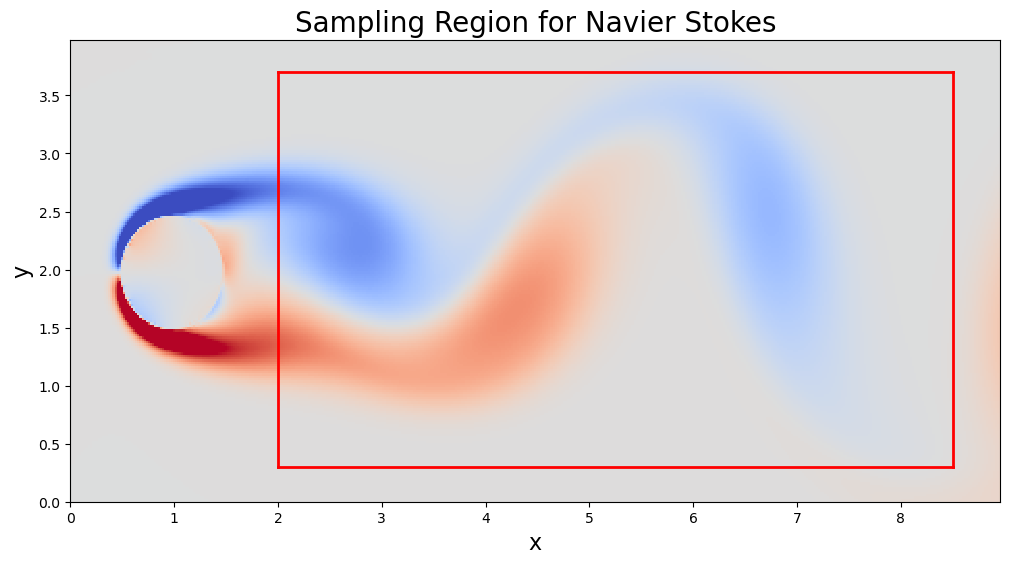

In [2]:
# Load data
steps = 151
n = 449
m = 199
U = np.load('../Datasets/course_timestep_cylinder/Cylinder_U.npy')
V = np.load('../Datasets/course_timestep_cylinder/Cylinder_V.npy')
W = np.load('../Datasets/course_timestep_cylinder/Cylinder_W.npy')

dt = 0.2
dx = 0.02
dy = 0.02

# plot the data
xx, yy = meshgrid(
    np.arange(449)*dx,
    np.arange(199)*dy)
pcolor(xx,yy,W[:,:,75].T,cmap='coolwarm', vmin=-4, vmax=4, shading='auto')

# Cut out the portion of the data before the cylinder
xmin = 100*dx
xmax = 425*dx
ymin = 15*dy
ymax = 185*dy
# newcut
# xmin = 80*dx
# xmax = 450*dx
# ymin = 0*dy
# ymax = 200*dy
plot([xmin,xmin],[ymin,ymax],'r',linewidth = 2)
plot([xmax,xmax],[ymin,ymax],'r',linewidth = 2)
plot([xmin,xmax],[ymin,ymin],'r',linewidth = 2)
plot([xmin,xmax],[ymax,ymax],'r',linewidth = 2)
xlim([0,n*dx-dx])
ylim([0,m*dy])
title('Sampling Region for Navier Stokes', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)

# originalV2
xmin = 100
xmax = 425+1
ymin = 15
ymax = 185+1

# original
# xmin = 100
# xmax = 425
# ymin = 15
# ymax = 185

# newcut
# xmin = 80
# xmax = 450
# ymin = 0
# ymax = 200

W = W[xmin:xmax,ymin:ymax,:]
U = U[xmin:xmax,ymin:ymax,:]
V = V[xmin:xmax,ymin:ymax,:]
n,m,steps = W.shape

# Add in noise with magnitude equal to 1% of std dev of data
noise_lv = 2
numpy.random.seed(0)
Wn = W + noise_lv*0.01*np.std(W)*np.random.randn(n,m,steps)
Un = U + noise_lv*0.01*np.std(U)*np.random.randn(n,m,steps)
Vn = V + noise_lv*0.01*np.std(V)*np.random.randn(n,m,steps)

In [3]:
print(U.shape[-1], V.shape[-1], W.shape[-1])
print((np.arange(449)*dx)[xmin:xmax])
print((np.arange(199)*dy)[ymin:ymax])

151 151 151
[2.   2.02 2.04 2.06 2.08 2.1  2.12 2.14 2.16 2.18 2.2  2.22 2.24 2.26
 2.28 2.3  2.32 2.34 2.36 2.38 2.4  2.42 2.44 2.46 2.48 2.5  2.52 2.54
 2.56 2.58 2.6  2.62 2.64 2.66 2.68 2.7  2.72 2.74 2.76 2.78 2.8  2.82
 2.84 2.86 2.88 2.9  2.92 2.94 2.96 2.98 3.   3.02 3.04 3.06 3.08 3.1
 3.12 3.14 3.16 3.18 3.2  3.22 3.24 3.26 3.28 3.3  3.32 3.34 3.36 3.38
 3.4  3.42 3.44 3.46 3.48 3.5  3.52 3.54 3.56 3.58 3.6  3.62 3.64 3.66
 3.68 3.7  3.72 3.74 3.76 3.78 3.8  3.82 3.84 3.86 3.88 3.9  3.92 3.94
 3.96 3.98 4.   4.02 4.04 4.06 4.08 4.1  4.12 4.14 4.16 4.18 4.2  4.22
 4.24 4.26 4.28 4.3  4.32 4.34 4.36 4.38 4.4  4.42 4.44 4.46 4.48 4.5
 4.52 4.54 4.56 4.58 4.6  4.62 4.64 4.66 4.68 4.7  4.72 4.74 4.76 4.78
 4.8  4.82 4.84 4.86 4.88 4.9  4.92 4.94 4.96 4.98 5.   5.02 5.04 5.06
 5.08 5.1  5.12 5.14 5.16 5.18 5.2  5.22 5.24 5.26 5.28 5.3  5.32 5.34
 5.36 5.38 5.4  5.42 5.44 5.46 5.48 5.5  5.52 5.54 5.56 5.58 5.6  5.62
 5.64 5.66 5.68 5.7  5.72 5.74 5.76 5.78 5.8  5.82 5.84 5.86 5.88 5

In [4]:
W = W.reshape(n*m,steps)
U = U.reshape(n*m,steps)
V = V.reshape(n*m,steps)

Wn = Wn.reshape(n*m,steps)
Un = Un.reshape(n*m,steps)
Vn = Vn.reshape(n*m,steps)

In [5]:
uw,sigmaw,vw = svd(W, full_matrices=False); vw = vw.T
uu,sigmau,vu = svd(U, full_matrices=False); vu = vu.T
uv,sigmav,vv = svd(V, full_matrices=False); vv = vv.T

uwn,sigmawn,vwn = svd(Wn, full_matrices=False); vwn = vwn.T
uun,sigmaun,vun = svd(Un, full_matrices=False); vun = vun.T
uvn,sigmavn,vvn = svd(Vn, full_matrices=False); vvn = vvn.T

Text(0.5, 1.0, 'Singular Values from Proper Orthogonal Decomposition\n (Dashed with noise)')

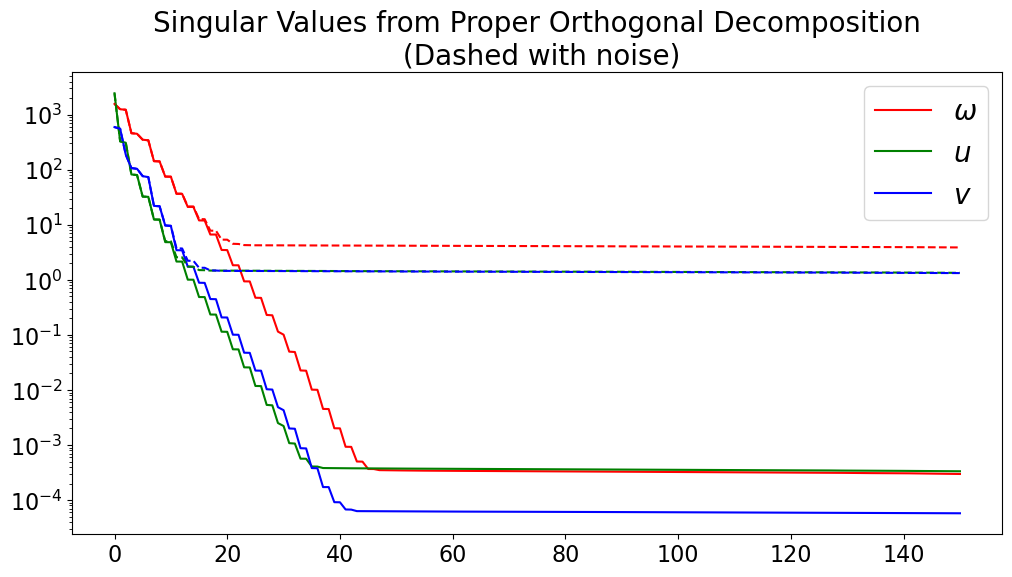

In [6]:
# singular values of clean data
semilogy(np.arange(151),sigmaw, 'r', label = r'$\omega$')
semilogy(np.arange(151),sigmau, 'g', label = r'$u$')
semilogy(np.arange(151),sigmav, 'b', label = r'$v$')

# singular values of noisy data
semilogy(np.arange(151),sigmawn, '--',color ='r')
semilogy(np.arange(151),sigmaun, '--',color ='g')
semilogy(np.arange(151),sigmavn, '--',color ='b')

legend(loc = 'upper right', fontsize = 20)
xticks(fontsize = 16)
yticks(fontsize = 16)

title('Singular Values from Proper Orthogonal Decomposition\n (Dashed with noise)', fontsize = 20)

In [7]:
dim_w = 26
dim_u = 20
dim_v = 20

Wn = uwn[:,0:dim_w].dot(np.diag(sigmawn[0:dim_w]).dot(vwn[:,0:dim_w].T)).reshape(n,m,steps)
Un = uun[:,0:dim_u].dot(np.diag(sigmaun[0:dim_u]).dot(vun[:,0:dim_u].T)).reshape(n,m,steps)
Vn = uvn[:,0:dim_v].dot(np.diag(sigmavn[0:dim_v]).dot(vvn[:,0:dim_v].T)).reshape(n,m,steps)

In [8]:
# Sample a collection of data points, stay away from edges so I can just use centered finite differences.
num_xy = 5000
num_t = 60
num_points = num_xy * num_t
boundary = 5
boundary_x = 10
points = {}
count = 0

for p in range(num_xy):
    x = np.random.choice(np.arange(boundary_x,n-boundary_x),1)[0]
    y = np.random.choice(np.arange(boundary,m-boundary),1)[0]
    for t in range(num_t):
        points[count] = [x,y,2*t+12]
        count = count + 1

In [ ]:
# Take derivatives of vorticity at each point.  Not the most elegant way of doing this...
#PolyDiffPoint(array of fcn vals, domain vals, degree, derivatives to take): -> array of derivatives  

# Take up to second order derivatives.
w = np.zeros((num_points,1))
u = np.zeros((num_points,1))
v = np.zeros((num_points,1))
wt = np.zeros((num_points,1))
wx = np.zeros((num_points,1))
wy = np.zeros((num_points,1))
wxx = np.zeros((num_points,1))
wxy = np.zeros((num_points,1))
wyy = np.zeros((num_points,1))

N = 2*boundary-1  # odd number of points to use in fitting
Nx = 2*boundary_x-1  # odd number of points to use in fitting
deg = 5 # degree of polynomial to use

for p in points.keys():
    
    [x,y,t] = points[p]
    w[p] = Wn[x,y,t]
    u[p] = Un[x,y,t]
    v[p] = Vn[x,y,t]
    
    wt[p] = PolyDiffPoint(Wn[x,y,t-(N-1)//2:t+(N+1)//2], np.arange(N)*dt, deg, 1)[0]
    
    x_diff = PolyDiffPoint(Wn[x-(Nx-1)//2:x+(Nx+1)//2,y,t], np.arange(Nx)*dx, deg, 2)
    y_diff = PolyDiffPoint(Wn[x,y-(N-1)//2:y+(N+1)//2,t], np.arange(N)*dy, deg, 2)
    wx[p] = x_diff[0]
    wy[p] = y_diff[0]
    
    x_diff_yp = PolyDiffPoint(Wn[x-(Nx-1)//2:x+(Nx+1)//2,y+1,t], np.arange(Nx)*dx, deg, 2)
    x_diff_ym = PolyDiffPoint(Wn[x-(Nx-1)//2:x+(Nx+1)//2,y-1,t], np.arange(Nx)*dx, deg, 2)
    
    wxx[p] = x_diff[1]
    wxy[p] = (x_diff_yp[0]-x_diff_ym[0])/(2*dy)
    wyy[p] = y_diff[1]

In [ ]:
# Form Theta using up to quadratic polynomials in all variables.
X_data = np.hstack([w,u,v])
X_ders = np.hstack([np.ones((num_points,1)), wx, wy, wxx, wxy, wyy])
X_ders_descr = ['','w_{x}', 'w_{y}','w_{xx}','w_{xy}','w_{yy}']
X, description = build_Theta(X_data, X_ders, X_ders_descr, 2, data_description = ['w','u','v'])

In [ ]:
description

In [ ]:
# 1%
# w_t = (0.010753 +0.000000i)w_{xx}
#     + (0.008376 +0.000000i)w_{yy}
#     + (-0.987751 +0.000000i)uw_{x}
#     + (-0.982905 +0.000000i)vw_{y}
# (6.6761, 6.053511902606623)
lam = 10**-5
d_tol = 5
c = TrainSTRidge(X,wt,lam,d_tol)
print_pde(c, description, ut = 'w_t')

In [ ]:
ground_coeffs = np.array([0.01, 0.01, -1, -1])
errs = np.abs(c[np.nonzero(c)[0], :].real.ravel()-ground_coeffs)/np.abs(ground_coeffs)
errs.mean(), errs.std()

In [ ]:
from misc import h5file
h5file('../Datasets/nv_originalV2_noiselv2.h5', {'X':X, 'wt':wt}, mode='w')
# h5file('../Datasets/nv_newcut_original_noiselv2.h5', {'X':X, 'wt':wt}, mode='w')

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import warnings; warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sympy import symbols

import sys; sys.path.append('../')
from PDE_FIND import *

import sys; sys.path.append('../../parametric-discovery/')
from best_subset import *
from frols import frols
from p_linear_regression import PLinearRegression
from r_pca import R_pca
from pde_diff_new import RPCA
from RobustPCA.rpca import RobustPCA

import scipy.io as sio
from scipy.signal import savgol_filter
import itertools

from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression as SkLinearRegression
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from abess.linear import LinearRegression
from bess import PdasLm
import pysindy as ps

from tqdm import trange
from os.path import join as join_path
FIGURE_EXPORT_PATH = "./"

from misc import h5file
import pickle
with open("../Datasets/nv_desc.pkl", "rb") as desc_fp:
    description = pickle.load(desc_fp)
ground_indices = (3, 5, 16, 24)
ground_coeffs = np.array([0.01, 0.01, -1, -1])

Populating the interactive namespace from numpy and matplotlib


In [2]:
Xr, wtr = h5file("../Datasets/nv_originalV2_noiselv2.h5")
# Xr, wtr = h5file("../Datasets/nv_newcut_original_noiselv2.h5")
Xr = Xr.real[:, 1:]
wtr = wtr.real
description = description[1:]

['X', 'wt']


In [3]:
combine = False
if not combine:
    newXr = Xr
else:
    # Combine features
    newXr = np.hstack((Xr, Xr[:, 2:3]+Xr[:, 4:5], Xr[:, 15:16]+Xr[:, 23:24]))
    description.append(f"{description[2]}+{description[4]}")
    description.append(f"{description[15]}+{description[23]}")
    newXr = np.delete(newXr, [2, 4, 15, 23], axis=1)
    print(description.pop(2))
    print(description.pop(4-1))
    print(description.pop(15-2))
    print(description.pop(23-3))

In [4]:
lam = 10**-6
d_tol = 5
c = TrainSTRidge(newXr,wtr,lam,d_tol)
print_pde(c, description, ut = 'w_t')

l0_penalty: 1.3911409799391343
w_t = (0.011551 +0.000000i)w_{xx}
    + (0.008421 +0.000000i)w_{yy}
    + (-0.980764 +0.000000i)uw_{x}
    + (-0.971890 +0.000000i)vw_{y}
    + (-0.009184 +0.000000i)uw_{yy}
    + (0.006396 +0.000000i)u^2w_{yy}
   


In [5]:
def ic(effective_indices, dataset, ic_type='bic'):
    s = len(effective_indices)
    XX, yy = dataset
    XX = XX[:, effective_indices]
    abess_model = LinearRegression(support_size=s, ic_type=ic_type, always_select=None)
    abess_model.fit(XX, yy)
    return abess_model.ic_

In [6]:
# if not combine:
#     errs = np.abs(c[nonz(c), :].real.ravel()-ground_coeffs)/np.abs(ground_coeffs)
#     errs.mean(), errs.std()

In [7]:
lrs = []
ebics = []
eff_indices = []
max_complexity = 10
for s in range(1, max_complexity):
    lr = LinearRegression(support_size=s, ic_type='bic', always_select=None)
    lr.fit(newXr, wtr)
    lrs.append(lr)
    eff_indices.append(nonz(lr.coef_))
    ebics.append(lr.ic_)
    print(nonz(lr.coef_))
    print(lr.ic_)
abess_feature_hierarchy = set(eff_indices)

(0,)
-785878.4859924914
(0, 23)
-828486.4829325224
(4, 15, 23)
-1414066.7207023033
(2, 4, 15, 23)
-1470722.63961428
(2, 4, 15, 23, 58)
-1484017.019592997
(2, 4, 15, 23, 27, 58)
-1490387.5126853492
(0, 2, 4, 15, 20, 23, 58)
-1494341.4384323033
(0, 2, 4, 15, 20, 23, 53, 58)
-1503827.9400486024
(0, 2, 4, 15, 20, 23, 27, 53, 58)
-1511354.8140244493


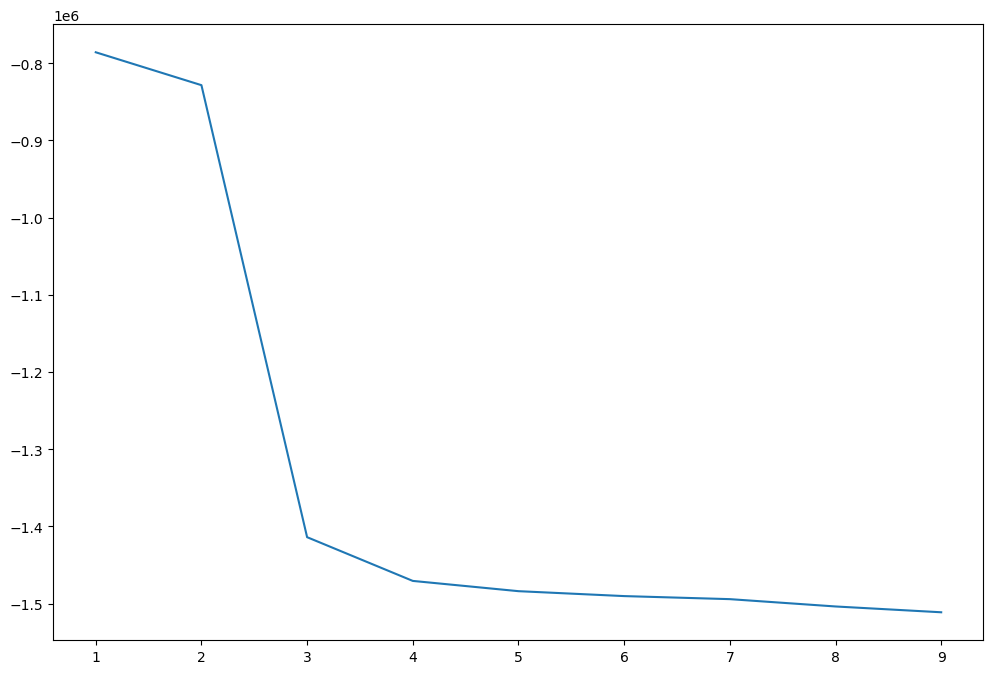

In [8]:
plt.plot([i for i in range(1, max_complexity)], ebics)
plt.show()

In [9]:
nor_axis = 0
if nor_axis is not None: Xfrols = normalize(newXr, axis=nor_axis)
else: Xfrols = newXr.copy()
frols_coeffs,selected_inds_list,_,_,_ = frols(wtr, Xfrols, max_nonzeros=max_complexity)
selected_inds_list = set(selected_inds_list)
selected_inds_list

{(0,),
 (0, 2, 4, 5, 15, 20, 23, 27, 53, 58),
 (0, 2, 4, 15, 20, 23),
 (0, 2, 4, 15, 20, 23, 27, 53, 58),
 (0, 2, 4, 15, 20, 23, 53),
 (0, 2, 4, 15, 20, 23, 53, 58),
 (0, 4, 15, 20, 23),
 (0, 15, 20),
 (0, 15, 20, 23),
 (0, 20)}

In [10]:
feature_hierarchy = abess_feature_hierarchy.union(selected_inds_list)

In [11]:
ic_type = 'bic' # bic, aic, aicc, hqic
br1 = backward_refinement(feature_hierarchy, (newXr, wtr), mode='rfe', ic_type=ic_type, verbose=True)
br2 = backward_refinement(feature_hierarchy, (newXr, wtr), mode='k best', ic_type=ic_type, verbose=True)
br_u=br1+br2; br_u

RFE_PLinearRegression
(2, 4, 15, 23, 27, 58)
(2, 4, 15, 23, 58)
(2, 4, 15, 23)
(4, 15, 23)
(15, 23)
(15,)
--------------------------------------------------
(0, 15, 20)
(0, 20)
(0,)
--------------------------------------------------
(2, 4, 15, 23)
--------------------------------------------------
(0, 4, 15, 20, 23)
(4, 15, 20, 23)
(4, 15, 23)
--------------------------------------------------
(0, 20)
--------------------------------------------------
(0, 2, 4, 15, 20, 23)
(2, 4, 15, 20, 23)
(2, 4, 15, 23)
--------------------------------------------------
(0, 2, 4, 15, 20, 23, 53, 58)
(0, 2, 4, 15, 20, 23, 53)
(2, 4, 15, 20, 23, 53)
(2, 4, 15, 23, 53)
(2, 4, 15, 23)
--------------------------------------------------
(0, 2, 4, 5, 15, 20, 23, 27, 53, 58)
(2, 4, 5, 15, 20, 23, 27, 53, 58)
(2, 4, 15, 20, 23, 27, 53, 58)
(2, 4, 15, 20, 23, 27, 53)
(2, 4, 15, 20, 23, 53)
--------------------------------------------------
(4, 15, 23)
--------------------------------------------------
(0, 23)

{1: ((0,), 273464.4246791447), 2: ((15, 23), -231816.91759647388), 3: ((4, 15, 23), -354759.4465943768), 4: ((2, 4, 15, 23), -411415.3523686379), 5: ((2, 4, 15, 23, 58), -424707.35307596525), 6: ((2, 4, 15, 20, 23, 53), -431197.6667018902), 7: ((2, 4, 15, 20, 23, 27, 53), -442226.8161312662), 8: ((2, 4, 15, 20, 23, 27, 53, 58), -449815.3193933275), 9: ((2, 4, 5, 15, 20, 23, 27, 53, 58), -454325.76663038024), 10: ((0, 2, 4, 5, 15, 20, 23, 27, 53, 58), -455643.04169511213)}

In [12]:
# AIC < AICC < HQIC < BIC (chk by plotting)

# BIC
# (0,) 273464.4246791447
# (15, 23) -231816.91759647388
# (4, 15, 23) -354759.4465943768
# (2, 4, 15, 23) -411415.3523686379
# (2, 4, 15, 23, 58) -424707.35307596525
# (2, 4, 15, 20, 23, 53) -431197.6667018902
# (2, 4, 15, 20, 23, 27, 53) -442226.8161312662
# (2, 4, 15, 20, 23, 27, 53, 58) -449815.3193933275
# (2, 4, 5, 15, 20, 23, 27, 53, 58) -454325.76663038024
# (0, 2, 4, 5, 15, 20, 23, 27, 53, 58) -455643.04169511213

# AIC
# (0,) 273453.81314139103
# (15, 23) -231838.14067198115
# (4, 15, 23) -354791.28120763774
# (2, 4, 15, 23) -411457.79851965245
# (2, 4, 15, 23, 58) -424760.41076473345
# (2, 4, 15, 20, 23, 53) -431261.33592841204
# (2, 4, 15, 20, 23, 27, 53) -442301.09689554165
# (2, 4, 15, 20, 23, 27, 53, 58) -449900.21169535664
# (2, 4, 5, 15, 20, 23, 27, 53, 58) -454421.27047016297
# (0, 2, 4, 5, 15, 20, 23, 27, 53, 58) -455749.1570726485

# AICC
# (0,) 273453.8131547244
# (15, 23) -231838.14063198076
# (4, 15, 23) -354791.28112763667
# (2, 4, 15, 23) -411457.7983863169
# (2, 4, 15, 23, 58) -424760.4105647294
# (2, 4, 15, 20, 23, 53) -431261.3356484055
# (2, 4, 15, 20, 23, 27, 53) -442301.09652219835
# (2, 4, 15, 20, 23, 27, 53, 58) -449900.2112153422
# (2, 4, 5, 15, 20, 23, 27, 53, 58) -454421.269870143
# (0, 2, 4, 5, 15, 20, 23, 27, 53, 58) -455749.1563392883

# HQIC
# (0,) 273456.8823655704
# (15, 23) -231832.00222362234
# (4, 15, 23) -354782.07353509957
# (2, 4, 15, 23) -411445.52162293484
# (2, 4, 15, 23, 58) -424745.06464383646
# (2, 4, 15, 20, 23, 53) -431242.9205833357
# (2, 4, 15, 20, 23, 27, 53) -442279.61232628586
# (2, 4, 15, 20, 23, 27, 53, 58) -449875.6579019215
# (2, 4, 5, 15, 20, 23, 27, 53, 58) -454393.6474525484
# (0, 2, 4, 5, 15, 20, 23, 27, 53, 58) -455718.46483085456

complexities = np.array(sorted(list(br_u.track.keys())))
bic_scores = []
eff_feature_names = []
for com in complexities:
    indices, bic = br_u.track[com]
    bic_scores.append(bic)
    print(indices, bic)
bic_scores = np.array(bic_scores)
min_bic_score = np.min(bic_scores)
div_scale = 1e3
rel_bic_scores = (bic_scores-min_bic_score)/div_scale

(0,) 273464.4246791447
(15, 23) -231816.91759647388
(4, 15, 23) -354759.4465943768
(2, 4, 15, 23) -411415.3523686379
(2, 4, 15, 23, 58) -424707.35307596525
(2, 4, 15, 20, 23, 53) -431197.6667018902
(2, 4, 15, 20, 23, 27, 53) -442226.8161312662
(2, 4, 15, 20, 23, 27, 53, 58) -449815.3193933275
(2, 4, 5, 15, 20, 23, 27, 53, 58) -454325.76663038024
(0, 2, 4, 5, 15, 20, 23, 27, 53, 58) -455643.04169511213


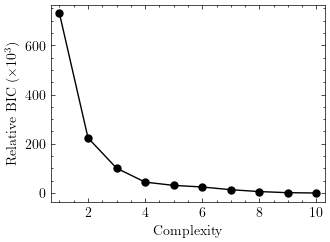

In [13]:
with plt.style.context('science'):
    fig, ax = plt.subplots()
    ax.plot(complexities, rel_bic_scores, color='black', linewidth=2.5//2)
    ax.scatter(complexities, rel_bic_scores, marker='o', c='black', s=25)
    plt.xlim(min(complexities)-0.3,max(complexities)+0.3)
    plt.ylabel(r"Relative BIC ($\times 10^{3}$)")
    plt.xlabel("Complexity")
    plt.tight_layout()
    plt.show()

In [14]:
# 2 improves 1
# Percent improve: 1.9044236199376305
# 3 improves 2
# Percent improve: 0.48272530938898894 0.22924950477530845
# 4 improves 3
# Percent improve: 0.1634190523811591 0.5019533061330647
# 5 does not improve 4
# Percent improve: 0.03336320357959099
d_bic_scores, d_coms, _ = get_decreasing_vals(bic_scores, complexities)
find_transition_V3(d_bic_scores, d_coms, 0.099)
find_transition_V4(d_bic_scores, d_coms, 0.099)
# bc = find_transition_V5(d_bic_scores, d_coms, 0.095, 0.005)
bc = find_transition_V5(d_bic_scores, d_coms, 0.09, 0.01)

2 improves 1
Percent improve: 1.847704113134512
3 improves 2
Percent improve: 0.5303432133970061 0.24331499842090112
4 improves 3
Percent improve: 0.15970231749470526 0.46083244127203127
5 does not improve 4
Percent improve: 0.032307984208176516
2 improves 1
Percent improve: 1.847704113134512
3 improves 2
Percent improve: 0.5303432133970061 0.24331499842090112
4 improves 3
Percent improve: 0.15970231749470526 0.46083244127203127
5 does not improve 4
Percent improve: 0.032307984208176516
2 improves 1
Percent improve: 1.847704113134512
3 improves 2
Percent improve: 0.24331499842090112
4 improves 3
Percent improve: 0.15970231749470526
5 does not improve 4
Percent improve: 0.032307984208176516


In [15]:
((wtr-newXr[:, br_u.track[bc][0]]@np.linalg.lstsq(newXr[:, br_u.track[bc][0]], wtr, rcond=None)[0])**2).mean()

0.014854837218703294

In [16]:
# Original: (16.35592842596212, 16.415838141227535)
# OriginalV2: (15.590001029825158, 15.529212575624166)
errs = 100*np.abs(np.linalg.lstsq(newXr[:, br_u.track[bc][0]], wtr, rcond=None)[0].flatten()-ground_coeffs)/np.abs(ground_coeffs)
errs.mean(), errs.std()

(15.590001029825158, 15.529212575624166)

In [17]:
bic_scores, complexities

(array([ 273464.42467914, -231816.91759647, -354759.44659438,
        -411415.35236864, -424707.35307597, -431197.66670189,
        -442226.81613127, -449815.31939333, -454325.76663038,
        -455643.04169511]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))

In [18]:
pred = np.linalg.lstsq(newXr[:, br_u.track[bc][0]], wtr, rcond=None)[0]
print_pde(pred, 
          np.array(description)[list(br_u.track[bc][0])], ut = 'w_t')

w_t = (0.011723 +0.000000i)w_{xx}
    + (0.005965 +0.000000i)w_{yy}
    + (-0.981318 +0.000000i)uw_{x}
    + (-0.970844 +0.000000i)vw_{y}
   


In [19]:
pred

array([[ 0.01172271],
       [ 0.00596508],
       [-0.98131837],
       [-0.97084411]])

In [20]:
metric_dict = {'raw_bic_scores': bic_scores, 
               'rel_bic_scores': rel_bic_scores, 
               'complexities': complexities, 
               'min_bic_score': min_bic_score, 
               'found_coeff': pred, 
               'percent_coefficient_error_mean': errs.mean(), 
               'percent_coefficient_error_std': errs.std()}
metric_dict

{'raw_bic_scores': array([ 273464.42467914, -231816.91759647, -354759.44659438,
        -411415.35236864, -424707.35307597, -431197.66670189,
        -442226.81613127, -449815.31939333, -454325.76663038,
        -455643.04169511]),
 'rel_bic_scores': array([729.10746637, 223.8261241 , 100.8835951 ,  44.22768933,
         30.93568862,  24.44537499,  13.41622556,   5.8277223 ,
          1.31727506,   0.        ]),
 'complexities': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'min_bic_score': -455643.04169511213,
 'found_coeff': array([[ 0.01172271],
        [ 0.00596508],
        [-0.98131837],
        [-0.97084411]]),
 'percent_coefficient_error_mean': 15.590001029825158,
 'percent_coefficient_error_std': 15.529212575624166}

In [21]:
# file_name = f"./Visualization/nv_originalV2_noiselv2_hqic.mat"
# print(file_name)
# sio.savemat(file_name, metric_dict)

In [22]:
# ic_type should be "aic", "bic", "ebic", "gic".
# For "aic", "bic", "ebic", "gic" -> use percent_ok = 0.01
# For "hic" -> use percent_ok = 0.05
ic_type = "ebic"

In [23]:
ic_scores = []
for com in complexities:
    effective_indices = br_u.track[com][0]
    ic_scores.append(ic(effective_indices, (newXr, wtr), ic_type=ic_type))

In [24]:
# Adding or substracting ic_scores with a substancial value -> different percent_ok...
# Better check with a wide range of simulated examples for a newly formulated information criterion
percent_ok = 0.09
# d_ic_scores, d_coms, _ = get_decreasing_vals(ic_scores+(min_bic_score, complexities))
d_ic_scores, d_coms, _ = get_decreasing_vals(ic_scores+(min_bic_score-np.min(ic_scores)), complexities)
bc = find_transition_V5(d_ic_scores, d_coms, percent_ok, 0.01)
rel_ic_scores = (ic_scores-np.min(ic_scores))/1e3

2 improves 1
Percent improve: 1.8480957588748486
3 improves 2
Percent improve: 0.24332377225257001
4 improves 3
Percent improve: 0.1596734563623158
5 does not improve 4
Percent improve: 0.032299127834855605


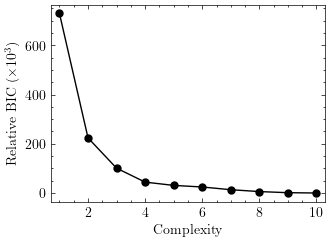

In [25]:
with plt.style.context('science'):
    fig, ax = plt.subplots()
    ax.plot(complexities, rel_ic_scores, color='black', linewidth=2.5//2)
    ax.scatter(complexities, rel_ic_scores, marker='o', c='black', s=25)
    plt.xlim(min(complexities)-0.3,max(complexities)+0.3)
    plt.ylabel(r"Relative BIC ($\times 10^{3}$)")
    plt.xlabel("Complexity")
    plt.tight_layout()
    plt.show()

In [26]:
metric_dict = {'raw_ic_scores': ic_scores, 
               'rel_ic_scores': rel_ic_scores, 
               'complexities': complexities, 
               'min_ic_score': np.min(ic_scores), 
               'found_coeff': pred, 
               'percent_coefficient_error_mean': errs.mean(), 
               'percent_coefficient_error_std': errs.std()}
metric_dict

{'raw_ic_scores': [-785878.4859924914,
  -1291122.298630275,
  -1414060.1290285713,
  -1470711.5492593911,
  -1484000.9252138727,
  -1490483.4396869086,
  -1501506.8698275522,
  -1509091.3560311839,
  -1513595.5312496445,
  -1514907.692993986],
 'rel_ic_scores': array([729.029207  , 223.78539436, 100.84756397,  44.19614373,
         30.90676778,  24.42425331,  13.40082317,   5.81633696,
          1.31216174,   0.        ]),
 'complexities': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'min_ic_score': -1514907.692993986,
 'found_coeff': array([[ 0.01172271],
        [ 0.00596508],
        [-0.98131837],
        [-0.97084411]]),
 'percent_coefficient_error_mean': 15.590001029825158,
 'percent_coefficient_error_std': 15.529212575624166}

In [27]:
file_name = f"./Visualization/nv_originalV2_noiselv2_{ic_type}.mat"
print(file_name)
# sio.savemat(file_name, metric_dict)

./Visualization/nv_originalV2_noiselv2_ebic.mat


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
FT = 8
plt.rcParams.update({'font.size': FT})
import numpy as np
import scipy.io as io

import sys
sys.path.append('./../../parametric-discovery/')
from best_subset import get_decreasing_vals, find_transition, find_transition_V2, find_transition_V3, find_transition_V4, find_transition_V5

from datetime import date
def today(): return date.today().strftime("%Y%m%d")
from os.path import join as join_path
FIGURE_EXPORT_PATH = "./visualization/vis_pics/"

In [2]:
file_name = f"./Visualization/nv_originalV2_noiselv2.mat"
data = io.loadmat(file_name)
raw_bic_scores = data['raw_bic_scores'][0]
rel_bic_scores = data['rel_bic_scores'][0]
complexities = data['complexities'][0]
d_bic_scores, d_coms, _ = get_decreasing_vals(raw_bic_scores, complexities)

In [3]:
bc = find_transition_V5(d_bic_scores, d_coms, 0.09, 0.01)

2 improves 1
Percent improve: 1.847704113134512
3 improves 2
Percent improve: 0.5303432133970061
4 improves 3
Percent improve: 0.15970231749470526
5 does not improve 4
Percent improve: 0.032307984208176516


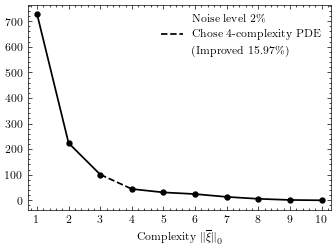

In [4]:
with plt.style.context('science'):
    fig, ax = plt.subplots()
    ax.plot([], [], ' ', label=f"Noise level 2\%")
    ax.plot(complexities[:3], rel_bic_scores[:3], color='black', linewidth=2.5/2)
    ax.plot(complexities[2:4], rel_bic_scores[2:4], '--', color='black', linewidth=2.5/2, label='Chose 4-complexity PDE')
    ax.plot(complexities[3:], rel_bic_scores[3:], color='black', linewidth=2.5/2)
    ax.scatter(complexities, rel_bic_scores, marker='o', c='black', s=25/2)
    ax.plot([], [], ' ', label=f"(Improved 15.97\%)")
    plt.xlim(min(complexities)-0.3,max(complexities)+0.3)
    plt.xticks([i for i in range(min(complexities), max(complexities)+1)])
    # plt.ylabel(r"Relative BIC ($\times 10^{3}$)", fontsize=FT)
    plt.xlabel(r"Complexity $\lVert\overline{\xi}\rVert^{}_{0}$", fontsize=FT)
    plt.tight_layout()
    plt.legend(fontsize=FT)
    # plt.savefig('./visualization/vis_pics/nv_V2.pdf')
    plt.show()

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
FT = 8
plt.rcParams.update({'font.size': FT})
import numpy as np
import scipy.io as io

import sys
sys.path.append('./../../parametric-discovery/')
from best_subset import get_decreasing_vals, find_transition, find_transition_V2, find_transition_V3, find_transition_V4, find_transition_V5

from datetime import date
def today(): return date.today().strftime("%Y%m%d")
from os.path import join as join_path
FIGURE_EXPORT_PATH = "./visualization/vis_pics/"

from matplotlib.text import Annotation
from matplotlib.transforms import Affine2D

class LineAnnotation(Annotation):
    """A sloped annotation to *line* at position *x* with *text*
    Optionally an arrow pointing from the text to the graph at *x* can be drawn.
    Usage
    -----
    fig, ax = subplots()
    x = linspace(0, 2*pi)
    line, = ax.plot(x, sin(x))
    ax.add_artist(LineAnnotation("text", line, 1.5))
    """

    def __init__(
        self, text, line, x, xytext=(0, 5), textcoords="offset points", **kwargs
    ):
        """Annotate the point at *x* of the graph *line* with text *text*.

        By default, the text is displayed with the same rotation as the slope of the
        graph at a relative position *xytext* above it (perpendicularly above).

        An arrow pointing from the text to the annotated point *xy* can
        be added by defining *arrowprops*.

        Parameters
        ----------
        text : str
            The text of the annotation.
        line : Line2D
            Matplotlib line object to annotate
        x : float
            The point *x* to annotate. y is calculated from the points on the line.
        xytext : (float, float), default: (0, 5)
            The position *(x, y)* relative to the point *x* on the *line* to place the
            text at. The coordinate system is determined by *textcoords*.
        **kwargs
            Additional keyword arguments are passed on to `Annotation`.

        See also
        --------
        `Annotation`
        `line_annotate`
        """
        assert textcoords.startswith(
            "offset "
        ), "*textcoords* must be 'offset points' or 'offset pixels'"

        self.line = line
        self.xytext = xytext

        # Determine points of line immediately to the left and right of x
        xs, ys = line.get_data()

        def neighbours(x, xs, ys, try_invert=True):
            inds, = np.where((xs <= x)[:-1] & (xs > x)[1:])
            if len(inds) == 0:
                assert try_invert, "line must cross x"
                return neighbours(x, xs[::-1], ys[::-1], try_invert=False)

            i = inds[0]
            return np.asarray([(xs[i], ys[i]), (xs[i+1], ys[i+1])])
        
        self.neighbours = n1, n2 = neighbours(x, xs, ys)
        
        # Calculate y by interpolating neighbouring points
        y = n1[1] + ((x - n1[0]) * (n2[1] - n1[1]) / (n2[0] - n1[0]))

        kwargs = {
            "horizontalalignment": "center",
            "rotation_mode": "anchor",
            **kwargs,
        }
        super().__init__(text, (x, y), xytext=xytext, textcoords=textcoords, **kwargs)

    def get_rotation(self):
        """Determines angle of the slope of the neighbours in display coordinate system
        """
        transData = self.line.get_transform()
        dx, dy = np.diff(transData.transform(self.neighbours), axis=0).squeeze()
        return np.rad2deg(np.arctan2(dy, dx))

    def update_positions(self, renderer):
        """Updates relative position of annotation text
        Note
        ----
        Called during annotation `draw` call
        """
        xytext = Affine2D().rotate_deg(self.get_rotation()).transform(self.xytext)
        self.set_position(xytext)
        super().update_positions(renderer)


def line_annotate(text, line, x, *args, **kwargs):
    """Add a sloped annotation to *line* at position *x* with *text*

    Optionally an arrow pointing from the text to the graph at *x* can be drawn.

    Usage
    -----
    x = linspace(0, 2*pi)
    line, = ax.plot(x, sin(x))
    line_annotate("sin(x)", line, 1.5)

    See also
    --------
    `LineAnnotation`
    `plt.annotate`
    """
    ax = line.axes
    a = LineAnnotation(text, line, x, *args, **kwargs)
    if "clip_on" in kwargs:
        a.set_clip_path(ax.patch)
    ax.add_artist(a)
    return a

In [2]:
file_name = f"./Visualization/nv_originalV2_noiselv2.mat"
raw_bic_scores = io.loadmat(file_name)['raw_bic_scores'][0]
rel_bic_scores = (raw_bic_scores-np.min(raw_bic_scores))/1e3
file_name = f"./Visualization/nv_originalV2_noiselv2_aic.mat"
raw_aic_scores = io.loadmat(file_name)['raw_bic_scores'][0]
rel_aic_scores = (raw_aic_scores-np.min(raw_bic_scores))/1e3
file_name = f"./Visualization/nv_originalV2_noiselv2_hqic.mat"
raw_hqic_scores = io.loadmat(file_name)['raw_bic_scores'][0]
rel_hqic_scores = (raw_hqic_scores-np.min(raw_bic_scores))/1e3

file_name = f"./Visualization/nv_originalV2_noiselv2_ebic.mat"
raw_ebic_scores = io.loadmat(file_name)['raw_ic_scores'][0]
file_name = f"./Visualization/nv_originalV2_noiselv2_gic.mat"
raw_gic_scores = io.loadmat(file_name)['raw_ic_scores'][0]
complexities = [i+1 for i in range(10)]

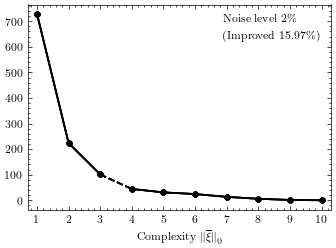

In [3]:
with plt.style.context('science'):
    fig, ax = plt.subplots()
    ax.plot([], [], ' ', label=f"Noise level 2\%")
    
    for rel_ic_scores in [rel_bic_scores, rel_aic_scores, rel_hqic_scores]:
        ax.plot(complexities[:3], rel_ic_scores[:3], color='black', linewidth=2.5/2)
        ax.plot(complexities[2:4], rel_ic_scores[2:4], '--', color='black', linewidth=2.5/2)
        ax.plot(complexities[3:], rel_ic_scores[3:], color='black', linewidth=2.5/2)
        ax.scatter(complexities, rel_ic_scores, marker='o', c='black', s=25/2)
    
    ax.plot([], [], ' ', label=f"(Improved 15.97\%)")
    plt.xlim(min(complexities)-0.3,max(complexities)+0.3)
    plt.xticks([i for i in range(min(complexities), max(complexities)+1)])
    # plt.ylabel(r"Relative BIC ($\times 10^{3}$)", fontsize=FT)
    plt.xlabel(r"Complexity $\lVert\overline{\xi}\rVert^{}_{0}$", fontsize=FT)
    plt.tight_layout()
    plt.legend(fontsize=FT)
    # plt.savefig('./visualization/vis_pics/nv_V2.pdf')
    plt.show()

In [4]:
NM = 300000

In [5]:
slope1 = (np.log(NM)-2)
print(slope1)
(raw_bic_scores-raw_aic_scores)/slope1

10.611537753638338


array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [6]:
slope2 = (np.log(NM)-2*(np.log(np.log(NM))))
print(slope2)
(raw_bic_scores-raw_hqic_scores)/slope2

7.542313574242394


array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [7]:
slope3 = (2*(np.log(np.log(NM))-1))
print(slope3)
(raw_hqic_scores-raw_aic_scores)/slope3

3.0692241793959436


array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [8]:
percent_ok = 0.09
d_ic_scores, d_coms, _ = get_decreasing_vals(raw_bic_scores, complexities)
bc = find_transition_V5(d_ic_scores, d_coms, percent_ok=percent_ok); print(bc)

percent_ok = 0.09
d_ic_scores, d_coms, _ = get_decreasing_vals(raw_aic_scores, complexities)
bc = find_transition_V5(d_ic_scores, d_coms, percent_ok=0.09); print(bc)

percent_ok = 0.09
d_ic_scores, d_coms, _ = get_decreasing_vals(raw_hqic_scores, complexities)
bc = find_transition_V5(d_ic_scores, d_coms, percent_ok=0.09); print(bc)

2 improves 1
Percent improve: 1.847704113134512
3 improves 2
Percent improve: 0.5303432133970061
4 improves 3
Percent improve: 0.15970231749470526
5 does not improve 4
Percent improve: 0.032307984208176516
4
2 improves 1
Percent improve: 1.8478146199852323
3 improves 2
Percent improve: 0.5303404356991382
4 improves 3
Percent improve: 0.15971789701013325
5 does not improve 4
Percent improve: 0.03233044140356868
4
2 improves 1
Percent improve: 1.847782656695757
3 improves 2
Percent improve: 0.5303412390532739
4 improves 3
Percent improve: 0.15971339116216482
5 does not improve 4
Percent improve: 0.032323946481278884
4


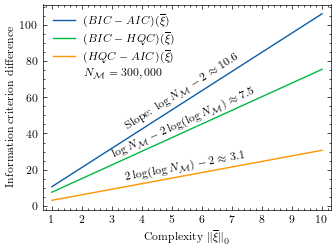

In [9]:
y1 = raw_bic_scores-raw_aic_scores
y2 = raw_bic_scores-raw_hqic_scores
y3 = raw_hqic_scores-raw_aic_scores
mid = (np.max(complexities)+1)/2
with plt.style.context('science'):
    p1, = plt.plot(complexities, y1, label=r"($BIC-AIC)(\overline{\xi})$")
    line_annotate(r'Slope: $\log{N_{\mathcal{M}}}-2 \approx 10.6$', p1, mid, fontsize=FT)
    p2, = plt.plot(complexities, y2, label=r"$(BIC-HQC)(\overline{\xi})$")
    line_annotate(r'$\log{N_{\mathcal{M}}}-2\log(\log{N_{\mathcal{M}}}) \approx 7.5$', p2, mid, fontsize=FT)
    p3, = plt.plot(complexities, y3, label=r"$(HQC-AIC)(\overline{\xi})$")
    line_annotate(r'$2\log(\log{N_{\mathcal{M}}})-2 \approx 3.1$', p3, mid, fontsize=FT)
    plt.plot([], [], ' ', label=r'$N_{\mathcal{M}}=300,000$')
    plt.xlim(min(complexities)-0.3,max(complexities)+0.3)
    plt.xticks([i for i in range(min(complexities), max(complexities)+1)])
    plt.xlabel(r"Complexity $\lVert\overline{\xi}\rVert^{}_{0}$", fontsize=FT)
    plt.ylabel("Information criterion difference", fontsize=FT)
    plt.tight_layout()
    plt.legend(fontsize=FT)
    # plt.savefig('./visualization/vis_pics/ic_comparison.pdf')
    plt.show()